In [1]:
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
import cv2
import pickle as pkl
import numpy as np

In [2]:
from tqdm.notebook import tqdm

In [3]:
keypoints_dict = pkl.load(open('keypoints_img_celeba.pkl', 'rb'))

In [4]:
df = pd.read_csv("celeba_meta_+yolo.csv")

In [5]:
df['filename'].nunique()

202205

In [6]:
from copy import copy

In [7]:
def cut(image, cords, im_size=112):
    face = copy(cords)
    target_size = im_size

    w = face[2] - face[0] + 1
    h = face[3] - face[1] + 1

    s = max(w, h)
    if (h < s):
        dh = s - h
        dh_up = face[1]
        dh_down = image.shape[0] - face[3] - 1
        if dh_up + dh_down < dh:
            face[1] = 0
            face[3] = image.shape[0] - 1
        else:
            dh_up_inc = dh // 2 + dh % 2
            dh_down_inc = dh // 2
            if dh_up < dh_up_inc:
                dh_down_inc += dh_up_inc - dh_up
                dh_up_inc = dh_up
            elif dh_down < dh_down_inc:
                dh_up_inc += dh_down_inc - dh_down
                dh_down_inc = dh_down
            face[1] -= dh_up_inc
            face[3] += dh_down_inc
                
    elif (w < s):
        dw = s - w
        dw_up = face[0]
        dw_down = image.shape[1] - face[2] - 1
        if dw_up + dw_down < dw:
            face[0] = 0
            face[2] = image.shape[1] - 1
        else:
            dw_up_inc = dw // 2 + dw % 2
            dw_down_inc = dw // 2
            if dw_up < dw_up_inc:
                dw_down_inc += dw_up_inc - dw_up
                dw_up_inc = dw_up
            elif dw_down < dw_down_inc:
                dw_up_inc += dw_down_inc - dw_down
                dw_down_inc = dw_down
            face[0] -= dw_up_inc
            face[2] += dw_down_inc
    
    if face[2] == image.shape[1]:
        face[2] -= 1
    if face[3] == image.shape[0]:
        face[3] -= 1
    if not (face[0] >= 0 and face[1] >= 0 and face[2] + 1 <= image.shape[1] and face[3] + 1 <= image.shape[0]):
        print(face, image.shape)
    assert face[0] >= 0 and face[1] >= 0 and face[2] <= image.shape[1] and face[3] <= image.shape[0]

    cut_face = image[face[1]:face[3] + 1, face[0]:face[2] + 1]
    distortion = (face[3] - face[1] + 1) / (face[2] - face[0] + 1)
    
    return cv2.resize(cut_face, (target_size, target_size)), face, distortion

In [8]:
IMG_SIZE = (112, 112, 3)

In [9]:
X_filename = list()
X = np.zeros((df['filename'].nunique(), IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]), dtype = np.uint8)
Y = np.zeros((df['filename'].nunique(), 136), dtype = np.uint8)

In [10]:
HAS_OUTOFSIZE_KEYPOINS = list()
WAS_DISTORTED = list()

In [11]:
def calc_level_out(x1, y1, x2, y2, shape):
    cnt = 0
    if x1 < 0:
        cnt += x1
    if x2 >= shape[1]:
        cnt += shape[1] - x2 + 1
    if y1 < 0:
        cnt += y1
    if y2 >= shape[0]:
        cnt += shape[0] - y2 + 1
    return cnt

In [12]:
for i in tqdm(range(df['filename'].nunique())):
    file = df['filename'][i]
    kp = np.copy(keypoints_dict[file])
    X_filename.append(file)
    image = io.imread("img_celeba/" + file)
    x1, x2, y1, y2 = df[df['filename'] == file][['x_1_bbox', 'x_2_bbox', 'y_1_bbox', 'y_2_bbox']].values[0]
    x2_from_kp = np.max(kp[:, 0])
    y2_from_kp = np.max(kp[:, 1])
    x1_from_kp = np.min(kp[:, 0])
    y1_from_kp = np.min(kp[:, 1])
    res = None
    type_of_cut = 1
    flag_outsize_kp = False
    if (x1_from_kp < 0) or (y1_from_kp < 0) or (x2_from_kp >= image.shape[1]) or (y2_from_kp >= image.shape[0]):
        x1_from_kp
        HAS_OUTOFSIZE_KEYPOINS.append((i, calc_level_out(x1_from_kp, y1_from_kp, x2_from_kp, y2_from_kp, image.shape)))
        flag_outsize_kp = True
    if ((x1 <= x1_from_kp) and  (y1 <= y1_from_kp) and (x2 >= x2_from_kp) and  (y2 >= y2_from_kp)) or flag_outsize_kp:
        res = cut(image, [x1, y1, x2, y2])
        if res[2] != 1.0 and not flag_outsize_kp:
            res = cut(image, [x1_from_kp, y1_from_kp, x2_from_kp, y2_from_kp])
            if res[2] != 1.0:
                WAS_DISTORTED.append((i, res[2]))
        elif flag_outsize_kp:
             WAS_DISTORTED.append((i, res[2]))
    else:
        x1 = np.min([x1, x1_from_kp])
        x2 = np.max([x2, x2_from_kp])
        y1 = np.min([y1, y1_from_kp])
        y2 = np.max([y2, y2_from_kp])
        res = cut(image, [x1, y1, x2, y2])
        if res[2] != 1.0:
            res = cut(image, [x1_from_kp, y1_from_kp, x2_from_kp, y2_from_kp])
            if res[2] != 1.0:
                WAS_DISTORTED.append((i, res[2]))
        type_of_cut = 2
        
    X[i] = res[0]
    kp_float_1 = (kp[:, 0] - res[1][0]).astype(float) * (112.0 / (res[1][2] - res[1][0]))
    kp_float_2 = (kp[:, 1] - res[1][1]).astype(float) * (112.0 / (res[1][3] - res[1][1]))
    kp[:, 0] = (kp[:, 0] - res[1][0]) * (112.0 / (res[1][2] - res[1][0]))
    kp[:, 1] = (kp[:, 1] - res[1][1]) * (112.0 / (res[1][3] - res[1][1]))
    
    if ((np.min(kp) < 0) or (np.max(kp) > 112)) and not flag_outsize_kp:
        print(np.max(kp_float_1), np.max(kp_float_2))
        print(res[1])
        print([x1, x2, y1, y2])
        print(file, type_of_cut, i)
        print(np.min(kp), np.max(kp))
        break
    
    Y[i] = kp.reshape(136,)

In [13]:
with open('X_ver2.pickle', 'wb') as f:
    pkl.dump(X, f, protocol=4)
    
with open('Y_ver2.pickle', 'wb') as f:
    pkl.dump(Y, f, protocol=4)
    
with open('X_filename.pickle', 'wb') as f:
    pkl.dump(X_filename, f, protocol=4)
    
with open('HAS_OUTOFSIZE_KEYPOINS.pickle', 'wb') as f:
    pkl.dump(HAS_OUTOFSIZE_KEYPOINS, f, protocol=4)
    
with open('WAS_DISTORTED.pickle', 'wb') as f:
    pkl.dump(WAS_DISTORTED, f, protocol=4)

In [14]:
len(HAS_OUTOFSIZE_KEYPOINS)

89

In [22]:
calc = 0
bad_index = set()
for i in range(len(HAS_OUTOFSIZE_KEYPOINS)):
    bad_index.add(HAS_OUTOFSIZE_KEYPOINS[i][0])

In [20]:
X_edit = np.zeros((X.shape[0] - len(HAS_OUTOFSIZE_KEYPOINS), IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]), dtype = np.uint8)
Y_edit = np.zeros((X.shape[0] - len(HAS_OUTOFSIZE_KEYPOINS), 136), dtype = np.uint8)

In [24]:
pos = 0
for i in tqdm(range(X.shape[0])):
    if i not in bad_index:
        X_edit[pos, :, :, :] = X[i, :, :, :]
        Y_edit[pos, :] = Y[i, :]
        pos += 1

In [25]:
with open('X_edited.pickle', 'wb') as f:
    pkl.dump(X_edit, f, protocol=4)
    
with open('Y_edited.pickle', 'wb') as f:
    pkl.dump(Y_edit, f, protocol=4)

In [26]:
X_edit.shape

(202116, 112, 112, 3)

In [177]:
file = '003630.jpg'
kp = np.copy(keypoints_dict[file])
X_filename.append(file)
image = io.imread("img_celeba/" + file)
x1, x2, y1, y2 = df[df['filename'] == file][['x_1_bbox', 'x_2_bbox', 'y_1_bbox', 'y_2_bbox']].values[0]
x2_from_kp = np.max(kp[:, 0])
y2_from_kp = np.max(kp[:, 1])
x1_from_kp = np.min(kp[:, 0])
y1_from_kp = np.min(kp[:, 1])
res = None
if (x1 <= x1_from_kp) and  (y1 <= y1_from_kp) and (x2 >= x2_from_kp) and  (y2 >= y2_from_kp):
    res = cut(image, [x1, y1, x2, y2])
else:
    res = cut(image, [x1_from_kp, y1_from_kp, x2_from_kp, y2_from_kp])
        
X[i] = res[0]
kp[:, 0] = (kp[:, 0] - res[1][0]) * (112.0 / (res[1][2] - res[1][0]))
kp[:, 1] = (kp[:, 1] - res[1][1]) * (112.0 / (res[1][3] - res[1][1]))

<function matplotlib.pyplot.show(*args, **kw)>

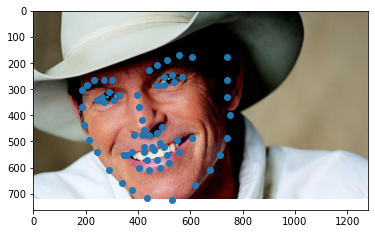

In [178]:
plt.imshow(image)
plt.scatter(keypoints_dict[file][:, 0], keypoints_dict[file][:, 1])
plt.show

In [72]:
image.shape

(408, 282, 3)

<function matplotlib.pyplot.show(*args, **kw)>

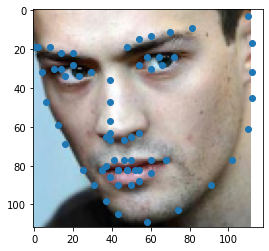

In [50]:
plt.imshow(res[0])
plt.scatter(kp[:, 0], kp[:, 1])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

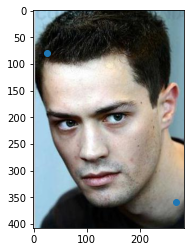

In [36]:
plt.imshow(image)
plt.scatter([x1, x2], [y1, y2])
plt.show

In [37]:
kp = np.copy(keypoints_dict[file])

In [38]:
x1, x2, y1, y2 = df[df['filename'] == file][['x_1_bbox', 'x_2_bbox', 'y_1_bbox', 'y_2_bbox']].values[0]
x2_from_kp = np.max(kp[:, 0])
y2_from_kp = np.max(kp[:, 1])
x1_from_kp = np.min(kp[:, 0])
y1_from_kp = np.min(kp[:, 1])
res = None
if (x1 <= x1_from_kp) and  (y1 <= y1_from_kp) and (x2 >= x2_from_kp) and  (y2 >= y2_from_kp):
    res = cut(image, [x1, y1, x2, y2])
else:
    res = cut(image, [x1_from_kp, y1_from_kp, x2_from_kp, y2_from_kp])

In [48]:
kp[:, 0] = (kp[:, 0] - res[1][0]) * (112.0 / (res[1][2] - res[1][0]))
kp[:, 1] = (kp[:, 1] - res[1][1]) * (112.0 / (res[1][3] - res[1][1]))

In [51]:
np.max(kp)

112

In [44]:
(112.0 / (res[1][2] - res[1][0]))

0.49557522123893805

In [8]:
with open('X_ver2.pickle', 'wb') as f:
    pkl.dump(X, f, protocol=4)
    
with open('Y_ver2.pickle', 'wb') as f:
    pkl.dump(Y, f, protocol=4)
    
with open('X_filename.pickle', 'wb') as f:
    pkl.dump(X_filename, f, protocol=4)

In [10]:
np.min(a)

0

In [66]:
kop = [1, 2, 3, 4]

In [74]:
kop[0:4]

[1, 2, 3, 4]

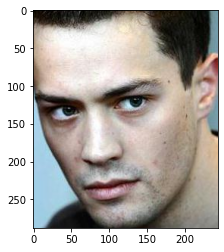

In [119]:
plt.imshow(image[79 : 367, 23 : 267])

245 289
289
2
!


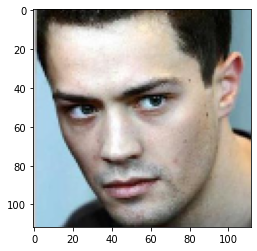

In [120]:
plt.imshow(cut(image, [23, 79, 267, 367])[0])